# Get activity data
___

This note notebook explore how to extract activity data and convert it into a data frame before to save it as a CSV file. It explore also how to change the temporal resolution of the activity.  

## Load input: packages, external functions, input data.

### Packages

In [10]:
# Load packages
using PyCall, PyPlot
pygui(:tk)
using DataFrames, CSV, Dates, StatsBase, Statistics, Tables, DataFramesMeta, BenchmarkTools
using Missings

### External Functions

In [72]:
# Include function file to extract and display accelerometer data
# Include the modules directory
dirFun = realpath(string(@__DIR__,"/../../temp/"))
include(dirFun*"/ActStatData.jl"); # include(dirFun*"/ActPlotData.jl"))
include(dirFun*"/GetAct.jl");
include(dirFun*"/GetBio.jl");
include(dirFun*"/ActTools.jl");
include(dirFun*"/AccDynamics.jl");

using .ActStatData

### Data

In [56]:
# List of visit directories
listDir = ["/../../../data/Baseline Visit Data/";
           "/../../../data/32 Week Gestation Data/";
           "/../../../data/6 Week PP Data/";
           "/../../../data/6 Months PP Data/";
           "/../../../data/12 Months PP Data/"]

# Visit Dictionary 
dictVisitName =  Dict(1=>"VisitBaseline",
                    2=>"Visit32w",
                    3=>"Visit6wPP",
                    4=>"Visit6mPP",
                    5=>"Visit12mPP");

# Load the group assignment information
groupFileName = realpath(string(@__DIR__, "/../../../data/Group/group_assignement.csv"))
global dfGroup = DataFrame!(CSV.File(groupFileName));
sort!(dfGroup);

## Get an individual activity data 

For example, let get the activity data frame of an individual from the Baseline directory:

In [13]:
# Get the path of the directory 
myDir = abspath(string(@__DIR__,listDir[1]));

# Get the data list files from the directory myDir
(actFiles, bioFiles) = ActStatData.filesNoNaN(myDir);

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\Baseline Visit Data\


Let return the activity and bio file names with respect to the index 3: 

In [18]:
println(actFiles[3]*"\n"*bioFiles[3])

040_BV_22May2017_Accel.csv
040_BV_22May2017_Accel_hdr.csv


In [24]:
length(bioFiles)

273

Get the activity data frame:

In [22]:
# Get any file and show columns of the data frame structure
idx = 3
df = ActStatData.readActivity(myDir*actFiles[idx]);
first(df, 3)

,Day,ElapsedSeconds,DateTime,ActivityCounts,Steps,EnergyExpenditure
,Int64,Int64,DateTime,Int64,Int64,Float64
1,1,180,2017-05-22T11:59:00,983,83,0.033
2,1,240,2017-05-22T12:00:00,1301,21,0.037
3,1,300,2017-05-22T12:01:00,1026,77,0.033


In [25]:
# Get complete days
ActStatData.getCompleteDays(df)

10

### GetIndivAct

`GetIndivAct` returns a vector containing the average of an activity type over maximum 7 days. It should returns also the ID and eventually the group

In [32]:
?GetIndivAct

search: GetIndivAct GetIndivID



**`GetIndivAct`** -*Function*.

```
`GetIndivAct(fileName::String; actType = 1, resmin::Int64 = 1, isavg::Bool = true)` => `vector`
```

Returns a vector containing the average of an activity type over maximum 7 days.

  * `filename` contains the path of the individual data in a specific folder.
  * `actype` indicates the type of activity to be processed (1=>:Activity Counts,  2=> number of Steps, 3=> Energy Expenditure, 4=> Activity Intensity)
  * `resmin` indicates temporal resolution of activity acquisition in minutes.
  * `isavg` is a boolean where true means that the return is the average data over one week and false means that the return is the full week cycle.


In [35]:
# Get complete days
idx = 21
df = ActStatData.readActivity(myDir*actFiles[idx]);
ActStatData.getCompleteDays(df)

5

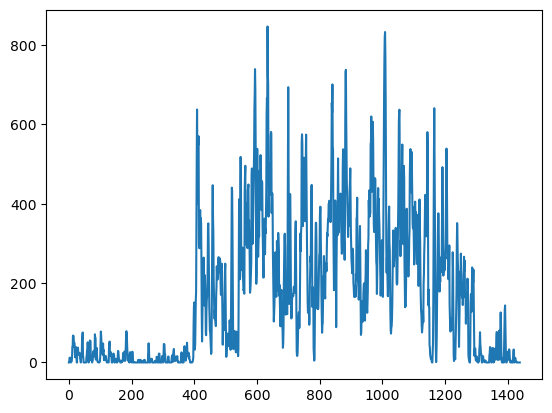

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000035E96490>

In [31]:
fileName = myDir * actFiles[21] # 107

# Get average Activity Count over 7 days
 vec = GetIndivAct(fileName, actType = 1, resmin = 1, isavg = true)
plot(vec)

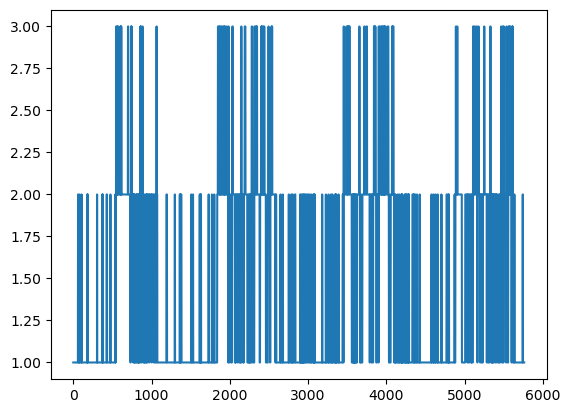

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000004AAC850>

In [45]:
# Get average Activity Intensity over 7 days
vec = GetIndivAct(fileName, actType = 4, resmin = 1, isavg = false)
plot(vec)

In [42]:
vecIntensity = GetIndivAct(fileName, actType = 4, resmin = 1, isavg = false);

In [43]:
countmap(vecIntensity)

Dict{Int64,Int64} with 3 entries:
  2 => 2145
  3 => 306
  1 => 3309

## Write Script to generate csv data

### Get directory activity 

Set the path the visit directory and a temporal resolution if desired.

In [133]:
# Select path of visit directory
idxDir = 5
myDir = abspath(string(@__DIR__,listDir[idxDir]))

# Set a temporal resolution
rmin = 60

60

Generate a data matrix containing values of one type of activity (*e.g.*, activity count, steps, intensity model...) and IDs vector with respect to each observation (row) of the data matrix.

In [134]:
# Activity type dictionary 
dictActType =  Dict(1=>"Acc",
                    2=>"Steps",
                    3=>"Xpndtr",
                    4=>"Ntnst");

In [135]:
# Get the data list files from the directory myDir
# (myData, myHeader) = ActStatData.filesNoNaN(myDir);
# myDir
# Get the matrix data
idxAct = 1
mat, vID = GetDirAct(myDir,actType = idxAct, resmin = rmin);
size(mat)

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\12 Months PP Data\


(24, 51)

### Check uniqueness

In [136]:
nonunique(vID)

Int64[]

In [137]:
findall(x -> x == 248, vID)

1-element Array{Int64,1}:
 23

In [138]:
# Get the data list files from the directory myDir
(dataFiles, bioFiles) = ActStatData.filesNoNaN(myDir);
bioFiles[findall(x -> x == 248, vID)]

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\12 Months PP Data\


1-element Array{String,1}:
 "248_12moPP_03Oct19_hdr.csv"

Join the activity information to the list with group assignment.

### Add group information

In [139]:
# Get Group assignment for the selected ID
myDf = DataFrame(studyID = vID)
dfAct = leftjoin(myDf, dfGroup, on = :studyID)

# Check for missing
numMiss = sum(ismissing.(dfAct.arm[:]))
println("Number of ID missing  : $numMiss")

Number of ID missing  : 0


In [140]:
# Drop missing
dfAct = dropmissing(dfAct);

### Convert matrix to data frame

In [141]:
# Convert matrix to data frame
df = Mat2DfAct(mat, vID, resmin = rmin)
first(df, 3)

,studyID,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00,T07h00
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,43,1638.83,3761.67,293.0,263.667,496.5,2681.33,24810.0,26173.7
2,47,1781.71,216.286,996.571,1008.71,272.714,41137.0,35577.9,26288.4
3,54,12179.8,3011.4,3173.4,342.8,148.0,710.0,33950.4,36143.6


Join the group assignment information:

In [142]:
# Left join
df = leftjoin(dfAct, df, on = :studyID);

# Check for missing data
findall(x -> ismissing(x), df.arm)


Union{}[]

### Save the activity data frame

Prepare the file name:

In [143]:
myFileName = string("m",dictVisitName[idxDir],"_", rmin,"_",
                    dictActType[idxAct], ".csv")

"mVisit12mPP_60_Acc.csv"

Save activity data frame:

In [144]:
csvFileName = string(@__DIR__,"/../../../data/fda/",myFileName)
CSV.write(csvFileName, df ; writeheader=true)

"C:\\git\\smartphysicalactivity\\develop\\test\\FDA/../../../data/fda/mVisit12mPP_60_Acc.csv"

## Generate and save activity differences between 2 consecutive visits

Load baseline and 32 weeks visits.

In [145]:
# Load data frame from the Baseline visit
myFileName = string("m",dictVisitName[1],"_", rmin,"_",
                    dictActType[idxAct], ".csv")
csvFileName = string(@__DIR__,"/../../../data/fda/", myFileName)
dfV1 = DataFrame!(CSV.File(csvFileName; comment = "#"));
size(dfV1)

(272, 26)

In [147]:
# Load data frame from the 32 weeks visit
myFileName = string("m",dictVisitName[2],"_", rmin,"_",
                    dictActType[idxAct], ".csv")
csvFileName = string(@__DIR__,"/../../../data/fda/", myFileName)
dfV2 = DataFrame!(CSV.File(csvFileName; comment = "#"))
size(dfV2)

(191, 26)

Build a dataframe containing the the activity data with the ID existing in the 32 weeks visit data frame.

In [150]:
# Keep IDs of the baseline visit in common with the next visit
df1 = DataFrame(studyID = dfV2.studyID);
df1 = innerjoin(df1, dfV1, on = :studyID);
size(df1)

(181, 26)

In [152]:
# # Keep IDs of the second visit in common with the first visit
df2 = DataFrame(studyID = df1.studyID);
df2 = innerjoin(df2, dfV2, on = :studyID);
size(df2)

(181, 26)

In [154]:
# test 
df1.studyID == df2.studyID

true

In [155]:
first(df1)

,studyID,arm,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00,T07h00
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,4,3,810.857,640.857,861.429,1477.43,18658.1,41676.3,24472.0,21237.7


### Get the difference between two visits

In [159]:
# Convert data frame activity into matrix 
mat21 = (log.(Matrix(df2[:, 3:end]).+1) - log.(Matrix(df1[:, 3:end]).+1 ));

In [160]:
d = names(@view df1[1,3:end]);

In [161]:
df21  = DataFrame([@view(mat21[:, i]) for i in 1:size(mat21, 2)], Symbol.(d))
insertcols!(df21, 1, :studyID => df1.studyID)
insertcols!(df21, 2, :arm => df1.arm);

### Save the diff data frame

In [164]:
# csvFileName = string(@__DIR__,"/../../../data/fda/","mBaselineSteps60.csv")
myFileName = string("m",dictVisitName[2], "-", dictVisitName[1],
                    "_", rmin,"_", dictActType[idxAct], ".csv")
csvFileName = string(@__DIR__,"/../../../data/fda/", myFileName)
CSV.write(csvFileName, df21 ; writeheader=true)

"C:\\git\\smartphysicalactivity\\develop\\test\\FDA/../../../data/fda/mVisit32w-VisitBaseline_60_Acc.csv"

## Accumulation

In [32]:
A = [1.0 2 3 4;1 2 3 4;1 2 3 4]
A =copy(transpose(A))

4×3 Array{Float64,2}:
 1.0  1.0  1.0
 2.0  2.0  2.0
 3.0  3.0  3.0
 4.0  4.0  4.0

In [33]:
GetAccAct(A)

4×3 Array{Float64,2}:
 1.0  2.0   3.0
 2.0  4.0   6.0
 3.0  6.0   9.0
 4.0  8.0  12.0

In [26]:
function GetAccAct(mat::Array{Float64, 2})
    
    mat = copy(transpose(mat))
        
    for  i = 1:size(mat)[2]
        mat[:,i] = accumulate(+, mat[:,i])
    end
        
    mat = copy(transpose(mat))
    
    return mat
    
end

GetAccAct (generic function with 2 methods)

In [ ]:
   # Transpose dataframe
    dfAct = DataFrame([[names(dfAct)]; collect.(eachrow(dfAct))], [:day; Symbol.(axes(dfAct, 1))])

## Extra

Add closest divisor:

Num = 636         # Numerator we are seeking to divide with no remainder
Den = 8           # Initial denominator
max_iters = 15    # caps the maximum loops
iters = 1         # initialize counter
Deni = Dend = Den # vars for searching increasing and decreasing denominators

while Num%Den != 0:
Deni +=1                 # searching increased vals
if Dend > 0 : Dend -=1   # searching decreased vals, but check 0 condition
if Num%Dend ==0:         # found a 0 remainder denominator
    Den = Dend           # assign found denominator
    break
elif Num%Deni ==0:       # found a 0 remainder denominator
    Den = Deni           # assign found denominator
    break
elif iters >= max_iters: # check loop count
    break
iters+=1